# Intelligent Architectures (5LIL0) Assignment 1 (version 0.3)

#### Authors: Marzieh Hashemipour-Nazari, Alexios Balatsoukas-Stimming, License: [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/)

## Part B: Multi-layer perceptron for handwritten digit recognition using PyTorch
In this notebook, we want to implement and train the same MLP as in Part A to classify images from the MNIST, but with the help of the PyTorch toolbox which simplifies the implementation. This procedure is broken into the following parts:
1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of the trained model on the test dataset

So, let's start with importing the required libraries and functions.

In [3]:
import os 
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import numpy as np

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline 

# For NN
import torch
import torch.nn as nn

# For loading the MNIST dataset
from torchvision import datasets, transforms 

# For reproducibility
torch.manual_seed(0)


## 1. Load the data

As in the previous part, we want to use the MNIST dataset. 
The MNIST dataset is provided by PyTorch using `datasets.MNIST()`. 
In addition, there are standard train and test splits that we can download by setting `train=True` and `train=False` for train and test dataset, respectively.

### 1.1 Tensors
Instead of arrays, we use **tensor** datatypes in PyTorch. Tensors are a mathematical construct used to express multi-dimensional arrays. Tensors allow any multi-dimensional structure to be represented by generalizing vectors (1-dimensional grid of numbers) and matrices (2-dimensional grid of numbers). Tensors are similar to Numpy's **ndarray**. However, they can also be used on GPUs to accelerate computing.

In [4]:
# Load the training data
mnist_train_set = datasets.MNIST('data', train=True, download = True, transform=transforms.ToTensor())
mnist_train_set = list(mnist_train_set)

mnist_test_set = datasets.MNIST('data', train=False, download = True, transform=transforms.ToTensor())
mnist_test_set = list(mnist_test_set)

print(f"Train dataset includes {len(mnist_train_set)} samples")
print(f"Test dataset includes {len(mnist_test_set)} samples")


Train dataset includes 60000 samples
Test dataset includes 10000 samples


### 1.2 MNIST visualization
Here again (similar to the first part of the lab), we just want to show how the data set looks like with a sample set example `mnist_img` including 5 samples from training dataset.

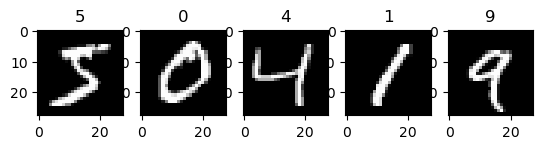

In [5]:
mnist_img = datasets.MNIST('data',train = True, download = True)
mnist_img = list(mnist_img)[:5]
# Plot some of images in the training data using subplot 
def show(data):
    figsize = len(data)
    for k, (image, label) in enumerate (data):
        plt.subplot(1,figsize,k+1)
        plt.imshow(image, cmap ='gray')
        plt.title(label)
show(mnist_img)


## 2. Define the network architecture
To follow the first part of the lab, we want to define a feed-forward, fully-connected network with 3 layers (i.e., input, hidden, and output layer).
To do so, we define the MLP class, which extends the `nn.Module` class. The `nn.Module` class instructs the implementation of our NN. It has two functions: `__init__`, which is the constructor, and `forward` to  implement the forward pass.
In the constructor, we first invoke the superclass initialization and then define the layers of our neural network. The `h_size` parameter controls the number of hidden neurons and defaults to $128$.
We stack all layers (two fully-connected layers with linear function to do the matrix multiplication) using `nn.Linear()`.

The `forward()` function first converts the image from a 2-dimensional format ($28\times 28$) to a 1-dimensional fomat ($784\times 1$) so it can be input into our NN with $784$ input neurons. Then, we apply the first layer followed by a __ReLU__ activation function. Note that the __sigmoid__ activation function is not included here as it is part of the cross-entropy loss function in PyTorch. All the standard activation functions are built in PyTorch.

In [6]:
class MNISTNN(nn.Module):
    def __init__(self,h_size=128):
        super(MNISTNN, self).__init__()
        self.layer1 = nn.Linear(28 * 28, h_size)
        self.layer2 = nn.Linear(h_size, 10)
        
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        X = self.layer1(flattened)
        O1 = torch.relu(X)
        O2 = self.layer2(O1)
        return O2

# Instantiate NN
model = MNISTNN()
print("Your model is:")
print(model)
print("\nCorrect model is:\nMNISTNN(\n  (layer1): Linear(in_features=784, out_features=128, bias=True)\n  (layer2): Linear(in_features=128, out_features=10, bias=True)\n)")

Your model is:
MNISTNN(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=10, bias=True)
)

Correct model is:
MNISTNN(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=10, bias=True)
)


## 3. Loss Function and Optimizer

PyTorch provides many built-in standard loss functions (including cross-entropy) with the `torch.nn` module. Notice that PyTorch's cross entropy function applies a softmax funtion to the output layer and then calculates the log loss, so we do not need to apply the softmax function explicitly. In addition to loss function, we need an optimizer to train the network. We used SGD optimization method in the first part, which we can easily call from `torch.optim` module.


In [7]:
# Specify loss function: categorical cross-entropy
criterion = nn.CrossEntropyLoss()

# Specify optimizer (stochastic gradient descent) and learning rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

### 3.1 Accuracy function
For the accuracy calculation, we need to implement the `accuracy()` function ourselves, which turns the probabilities into a prediction based on the highest probability, as in part 1.

In [8]:
def accuracy(outputs,labels):
    _, preds = torch.max(outputs.data, 1) # get the index of the max log-probability 
#     pred = outputs.max(1, keepdim=True)[1]  #alternative
    correct = (preds== labels).sum().item()/labels.shape[0] # equality check
#     correct = pred.eq(labels.view_as(pred)).sum().item()/labels.shape[0] # alternative
    return correct

## 4. Training the network
Now, we are ready to train our network using PyTorch. We need to do the following steps for one epoch at each batch
- Use the defined model to make the predictions for n = batch_size images
- Compute the average loss over the predicted values
- Compute the parameter updates using `loss.backward()` function
- Update each parameter using `optimizer.step()` function 

### 4.1 Defining the training function
As PyTorch accumulates the gradients on subsequent backward passes, we need to to set the gradient to 0 before starting the next mini-batch. Otherwise, the gradient would be a combination of the old gradient, which you have already used to update your model parameters, and the newly-computed gradient. The function `optimizer.zero_grad()` does this clean-up step for us.

As said before, the appropriate batch size depends on many parameters. But in general, we need the batch size to be large enough so that the gradients are not too "noisy", but not so large as to make each iteration too expensive to run. Here, to have the same model as the first part, let's set `batch_size = 500`. Notice that `torch.utils.data.DataLoader()` helps us to divide the dataset into mini-batches with the size of `batch_size`.

Now, we define the `train()` function, which gets `model`, `data_train`, `data_test`, `batch_size`, and `num_epochs` as the inputs for NN model, train set, test set, size of mini batches, number of epochs, respectively.
In addition, we define a boolean `log` variable, which determines the accuracy and loss values for the training and test set should be printed out or not.


In [9]:
def train(model,data_train,data_test,batch_size=20,num_epochs=1,log=False):
    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,shuffle=True)
    test_loader  = torch.utils.data.DataLoader(data_test, batch_size=batch_size)

    # Lists for saving the value of loss and accuracy of each epoch
    loss_list_train = list()
    train_acc = list()
    test_acc = list()
    loss_list_test = list()

    # Training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        #clean-up step for each epoch
        correct_train = 0
        correct_test  = 0
        loss_train    = 0
        loss_test     = 0

        for imgs, labels in iter(train_loader):
            # Put model in training mode (required for dropout)
            model.train()
            # Forward pass
            out = model.forward(img=imgs)
            # Compute the loss
            loss = criterion(out, labels)
            loss_train += loss/batch_size
            # Backward pass (compute parameter updates)
            loss.backward()
            # Update parameters
            optimizer.step()
            # Erase gradients for next batch
            optimizer.zero_grad()         
            correct_train += accuracy(out,labels)

        # Save the loss and accuracy for current epoch
        loss_list_train.append(float(loss_train)/len(train_loader)) # compute *average* loss
        train_acc.append(correct_train/len(train_loader))

        # Validate our model on the test set
        for imgs_test,labels_test in iter(test_loader):
            # Put model in evaluation mode (required for dropout)
            model.eval()
            out_test = model.forward(img=imgs_test)
            correct_test += accuracy(out_test,labels_test)
            loss_test += criterion(out_test, labels_test)/batch_size

        # Compute validation accuracy
        test_acc.append(correct_test/len(test_loader))  
        loss_list_test.append(float(loss_test)/len(test_loader))
        if(log):
            print(f"Epoch {epoch+1}: train_loss = {float(loss_train)/len(train_loader):.4f} | train_acc = {correct_train/len(train_loader):.3f} | test_loss = {float(loss_test)/len(test_loader):.4f} | test_acc = {correct_test/len(test_loader):.3f}" )
    
    print(f"\nYour performance after {num_epochs} epoch(s) is: train_loss = {float(loss_train)/len(train_loader):.4f} | train_acc = {correct_train/len(train_loader):.3f} | test_loss = {float(loss_test)/len(test_loader):.4f} | test_acc = {correct_test/len(test_loader):.3f}\n" )
    
    # Plot learning curves
    fig,ax = plt.subplots(1,2,figsize=(15,5))

    ax[0].plot(loss_list_train,label="Train loss")
    ax[0].plot(loss_list_test,label="Test loss")
    ax[0].legend()
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].grid()

    ax[1].plot(train_acc,label="Train accuracy")
    ax[1].plot(test_acc,label="Test accuracy")
    ax[1].legend()
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].grid()

### 4.2 Running the training
We can now put everything together to train our neural network. You will notice that the training may be slower than in part 1 of the assignment (unless you use GPU acceleration). This is because PyTorch is made to be very general and its functions have certain overheads, while your implementation in part 1 only contained the essential steps but was less flexible. There is usually a fundamental trade-off between generality and speed.

Epoch 1: train_loss = 0.0030 | train_acc = 0.689 | test_loss = 0.0016 | test_acc = 0.836
Epoch 2: train_loss = 0.0013 | train_acc = 0.854 | test_loss = 0.0010 | test_acc = 0.877
Epoch 3: train_loss = 0.0009 | train_acc = 0.879 | test_loss = 0.0008 | test_acc = 0.890
Epoch 4: train_loss = 0.0008 | train_acc = 0.890 | test_loss = 0.0007 | test_acc = 0.899
Epoch 5: train_loss = 0.0007 | train_acc = 0.897 | test_loss = 0.0007 | test_acc = 0.902
Epoch 6: train_loss = 0.0007 | train_acc = 0.901 | test_loss = 0.0007 | test_acc = 0.908
Epoch 7: train_loss = 0.0007 | train_acc = 0.905 | test_loss = 0.0006 | test_acc = 0.909
Epoch 8: train_loss = 0.0006 | train_acc = 0.908 | test_loss = 0.0006 | test_acc = 0.914
Epoch 9: train_loss = 0.0006 | train_acc = 0.911 | test_loss = 0.0006 | test_acc = 0.917
Epoch 10: train_loss = 0.0006 | train_acc = 0.914 | test_loss = 0.0006 | test_acc = 0.919
Epoch 11: train_loss = 0.0006 | train_acc = 0.917 | test_loss = 0.0006 | test_acc = 0.921
Epoch 12: train_los

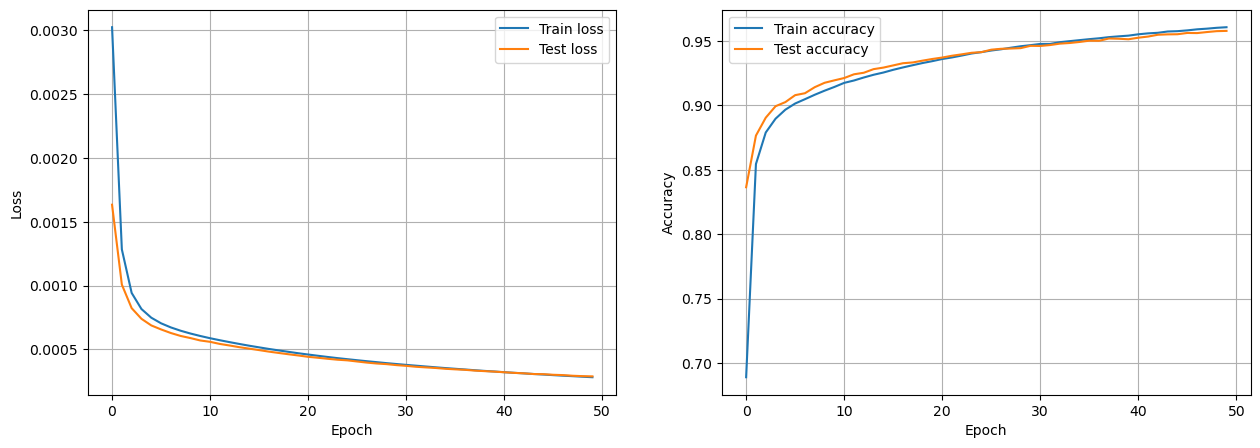

In [10]:
# Initialize NN and hyperparameters
torch.manual_seed(0)
model = MNISTNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
batch_size = 500
num_epochs = 50

# Run training
train(model,mnist_train_set,mnist_test_set,batch_size,num_epochs,log=True)

print('Correct performance after 50 epochs is: train_loss = 0.0003 | train_acc = 0.961 | test_loss = 0.0003 | test_acc = 0.958')

## 5. Overfitting 
Ideally, we want to select a model that learns the structure of the training data to the extent that it can also work well on new data. However, sometimes a model pays too much attention to training-data specific details and does not generalize well to other data. This undesirable behaviour is called __overfitting__ and can happen due to several reasons:

- Small training dataset, which does not contain enough data to represent all possible input data values
- The model is too complex for the dataset
- The model trains too long with unnecessarly large number of epochs 

Now, we will train the same model as before but we will use 100 training samples, 200 epochs, and SGD with $\eta=0.05$ to force our neural network to overfit (you should see a significant distance between the training and test curves):

Train dataset size: 100
Test dataset size: 1000

Epoch 1: train_loss = 0.2242 | train_acc = 0.310 | test_loss = 0.2211 | test_acc = 0.360
Epoch 2: train_loss = 0.2055 | train_acc = 0.560 | test_loss = 0.2114 | test_acc = 0.379
Epoch 3: train_loss = 0.1844 | train_acc = 0.590 | test_loss = 0.1993 | test_acc = 0.486
Epoch 4: train_loss = 0.1619 | train_acc = 0.680 | test_loss = 0.1856 | test_acc = 0.521
Epoch 5: train_loss = 0.1392 | train_acc = 0.770 | test_loss = 0.1721 | test_acc = 0.529
Epoch 6: train_loss = 0.1198 | train_acc = 0.800 | test_loss = 0.1600 | test_acc = 0.545
Epoch 7: train_loss = 0.1002 | train_acc = 0.840 | test_loss = 0.1497 | test_acc = 0.583
Epoch 8: train_loss = 0.0858 | train_acc = 0.870 | test_loss = 0.1407 | test_acc = 0.598
Epoch 9: train_loss = 0.0727 | train_acc = 0.870 | test_loss = 0.1327 | test_acc = 0.612
Epoch 10: train_loss = 0.0624 | train_acc = 0.910 | test_loss = 0.1278 | test_acc = 0.631
Epoch 11: train_loss = 0.0537 | train_acc = 0.970 | test_los

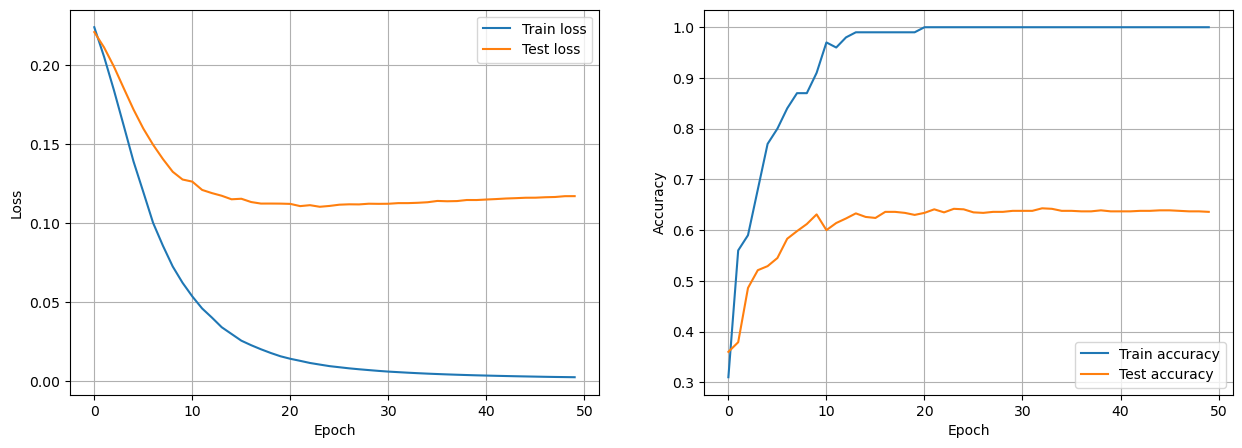

In [11]:
# Initialize NN and hyperparameters
torch.manual_seed(0)
model = MNISTNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
batch_size = 10
num_epochs = 50

# Choose train and test samples
n_train = 100
n_test = 1000 
mnist_train  = mnist_train_set[:n_train]
mnist_test   = mnist_test_set[:n_test]

print(f"Train dataset size: {len(mnist_train)}")
print(f"Test dataset size: {len(mnist_test)}\n")

# Run training (this may take a while, set log=True if you want to see the progress)
train(model,mnist_train,mnist_test,batch_size,num_epochs,log=True)

print('Correct performance after 50 epochs is: train_loss = 0.0025 | train_acc = 1.000 | test_loss = 0.1172 | test_acc = 0.636')

## Preventing overfitting
We will now explore three ways to prevent overfitting:
- Data augmentation
- Regularization
- Dropout

As you will see, some are more effective than others, at least in our example.

### 5.1 Data augmentation
In our example, the MNIST dataset has more training samples and we could just use those. However, in practice it is often expensive to gather more data and __data augmentation__ is used to generate more data from existing data using small alterations. Some common data augmentation techniques for an image data set are listed below:
- Rotating the images a bit using `transforms.RandomRotation(rotation_degree)`
- Shifting the pixels of images
- Adding noise to the image

Let's try the first one and see the result on the training model.

Training samples: Without augmentation 


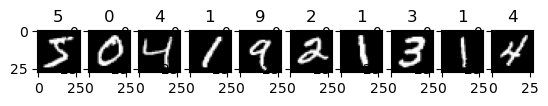

In [12]:
# Re-load and display the dataset
limit = 500
mnist_imgs = datasets.MNIST('data', train=True, download=True)
mnist_imgs = list(mnist_imgs)[:limit]
print('Training samples: Without augmentation ')
show(mnist_imgs[:10])


Training samples: Randomly rotated by up to 25 degrees


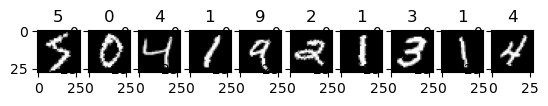

In [13]:
# Re-load with rotation of randomly selected images
print('Training samples: Randomly rotated by up to 25 degrees')
mnist_rot = datasets.MNIST('data', train=True, download=True,transform=transforms.RandomRotation(25),)
mnist_rot = list(mnist_rot)[:limit]
show(mnist_rot[:10])

Every time we apply the transformation, we get different images as the rotation is done randomly. Therefore, we can augment our data set by randomly rotating each training data point 10 times for example:

In [14]:
augmented_data = []
n_train = 100
torch.manual_seed(0)
for i in range(10):
    mnist_aug = datasets.MNIST('data', train=True, download=True, transform=transforms.Compose([transforms.RandomRotation(25),transforms.ToTensor()]))
    mnist_aug = list(mnist_aug)[:n_train]
    for j, item in enumerate(mnist_aug):
        # print(type(item), item[0].size(), item[1])  # <class 'tuple'> torch.Size([1, 28, 28]) 5
        augmented_data.append(item)

len(augmented_data)

1000

Now, let's train our model with new augmented dataset which includes 1000 samples instead of 100.

Augmented train dataset size: 1000
Test dataset size: 1000


Your performance after 50 epoch(s) is: train_loss = 0.0003 | train_acc = 1.000 | test_loss = 0.1361 | test_acc = 0.703

Correct performance after 50 epochs is: train_loss = 0.0003 | train_acc = 1.000 | test_loss = 0.1360 | test_acc = 0.699


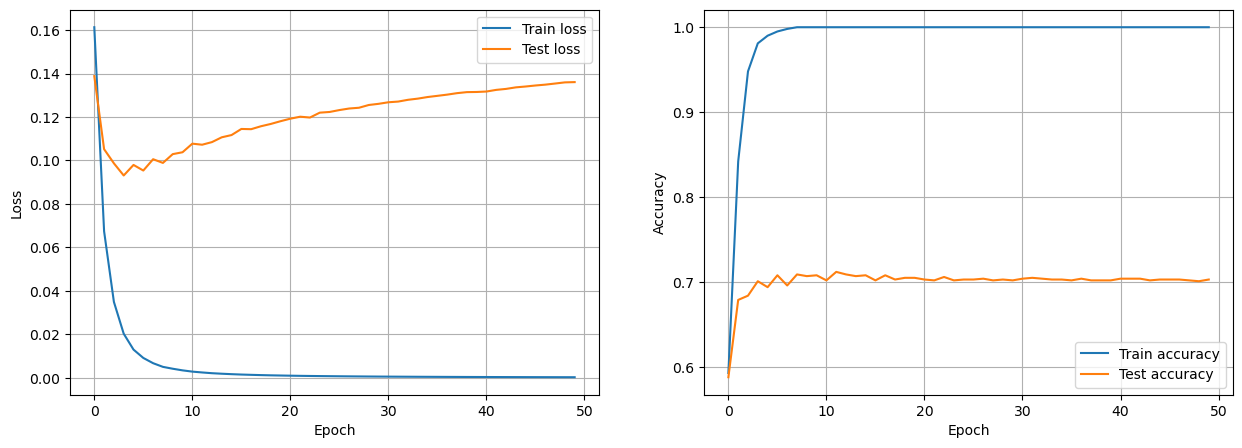

In [15]:
# Initialize NN and hyperparameters
torch.manual_seed(0)
model = MNISTNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
batch_size = 10
num_epochs = 50

# Choose test samples
n_test = 1000 
mnist_test   = mnist_test_set[:n_test]

# Data augmentaion
augmented_data = []
n_train = 100
torch.manual_seed(0)
for i in range(10):
    mnist_aug = datasets.MNIST('data', train=True, download=True, transform=transforms.Compose([transforms.RandomRotation(25),transforms.ToTensor()]))
    mnist_aug = list(mnist_aug)[:n_train]
    for j, item in enumerate(mnist_aug):
        # print(type(item), item[0].size(), item[1])  # <class 'tuple'> torch.Size([1, 28, 28]) 5
        augmented_data.append(item)

print(f"Augmented train dataset size: {len(augmented_data)}")
print(f"Test dataset size: {len(mnist_test)}\n")

# Run training (this may take a while, set log=True if you want to see the progress)
train(model,augmented_data,mnist_test,batch_size,num_epochs,log=False)

print('Correct performance after 50 epochs is: train_loss = 0.0003 | train_acc = 1.000 | test_loss = 0.1360 | test_acc = 0.699')

### 5.2 Weight Regularization/Weight Decay
Usually, large weights in an NN are a sign of a complex network that can lead to overfitting.
The idea of __weight regularization__ is to decay (penalize) large weights because they can make the prediction depend too much on the content of a few pixels, leading to overfitting. Large weights can be penalized by adding an extra term to the loss function. This can be, e.g., the sum of absolute values of the weights $\sum_n |w_n|$ (known as $L^1$-regularization) or the sum of squares of the weights $\sum_n |w_n|^2$ (known as $L^2$-regularization). $L^1$-regularization encourages sparse weights, which can be useful when applying pruning (which we will see in following lectures and assignments).

Weight decay can be automatically done with pyTorch, using the `weight_decay` parameter of the `optim.SGD()` command, which uses $L^2$-regularization. So, the regularized loss function is calculated as:

$$ 
C_{\text{Reg}} = C +\lambda \sum_n w_n^2,
$$

where $\lambda$ is the regularization coefficient, and the update for a weight $w$ at training iteration $t$ becomes:

$$
w_{t} = w_{t-1}-\eta\left(\frac{\partial C}{\partial w_{t-1}}+2\lambda w_{t-1}\right),
$$

where $\eta$ is the learning rate. We can set the value of $\lambda$ with the `weight_decay` parameter for `optim.SGD()` optimizer (the default is $\lambda=0$ which results in no weight decay). Let's run the training again with the non-augmented dataset of 100 samples and a weight decay parameter $\lambda = 0.05$ and the same value of $\eta$ as before:

Train dataset size: 100
Test dataset size: 1000


Your performance after 50 epoch(s) is: train_loss = 0.0199 | train_acc = 1.000 | test_loss = 0.1145 | test_acc = 0.637

Correct performance after 50 epochs is: train_loss = 0.0199 | train_acc = 1.000 | test_loss = 0.1145 | test_acc = 0.637


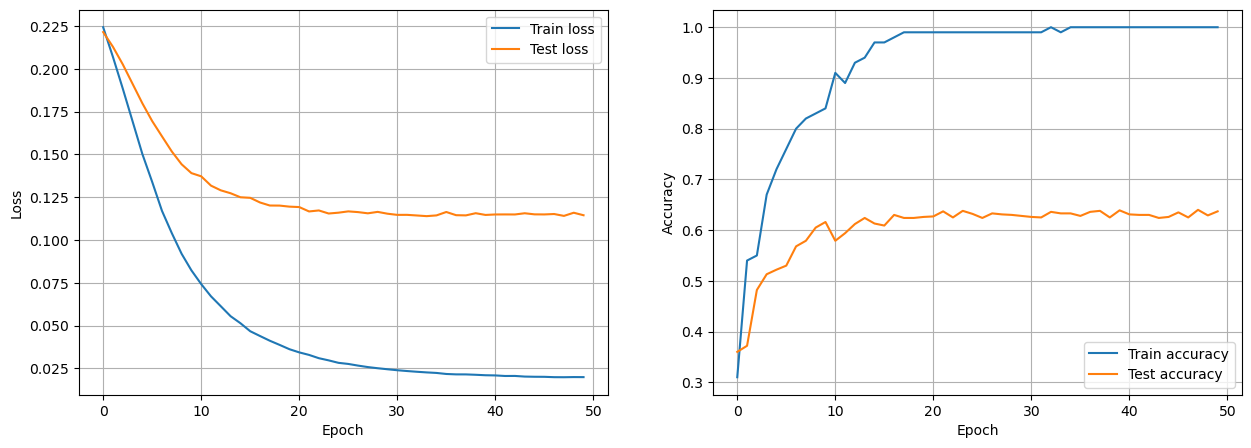

In [16]:
# Initialize NN and hyperparameters
torch.manual_seed(0)
model = MNISTNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, weight_decay=0.05)
batch_size = 10
num_epochs = 50

# Choose train and test samples
n_train = 100
n_test = 1000 
mnist_train  = mnist_train_set[:n_train]
mnist_test   = mnist_test_set[:n_test]

print(f"Train dataset size: {len(mnist_train)}")
print(f"Test dataset size: {len(mnist_test)}\n")

# Run training (this may take a while, set log=True if you want to see the progress)
train(model,mnist_train,mnist_test,batch_size,num_epochs,log=False)

print('Correct performance after 50 epochs is: train_loss = 0.0199 | train_acc = 1.000 | test_loss = 0.1145 | test_acc = 0.637')

### 5.3 Dropout
The other way to reduce overfitting is to remove some randomly selected neurons/weights in each training iteration. Note that we use __dropout__ during the training but not during the testing of the NN. We can set the dropout rate for each layer using `nn.Dropout(dropout_rate)` in PyTorch when defining the NN model. The dropout rate is the probability of removing a particular node in a layer. 
For example, if the dropout rate of a layer is 0.3, neurons will have a 70% probability of remaining active and a 30% probability of being removed from that layer for each mini-batch. Note that the dropout layer must comea *before* the layer it should be applied to in the code.

Let's define a new NN model `MNISTNNDropout(nn.Module)` that uses dropout in the input and hidden layers with a dropout rate of 0.6:

In [17]:
# Create MLP with dropout
class MNISTNNDropout(nn.Module):
    def __init__(self,h_size=128):
        super(MNISTNNDropout, self).__init__()
        self.layer1 = nn.Linear(28 * 28, h_size)
        self.layer2 = nn.Linear(h_size, 10)
        self.dropout = nn.Dropout(0.6) 
        
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        X = self.dropout(flattened)
        X = self.layer1(X)
        O1 = torch.relu(X)
        O1 = self.dropout(O1)
        O2 = self.layer2(O1)
        O2 = torch.sigmoid(O2)
        return O2

Now we can train the model with the same parameters as before:

Train dataset size: 100
Test dataset size: 1000


Your performance after 50 epoch(s) is: train_loss = 0.1799 | train_acc = 0.750 | test_loss = 0.1950 | test_acc = 0.599

Correct performance after 50 epochs is: train_loss = 0.1799 | train_acc = 0.750 | test_loss = 0.1950 | test_acc = 0.599


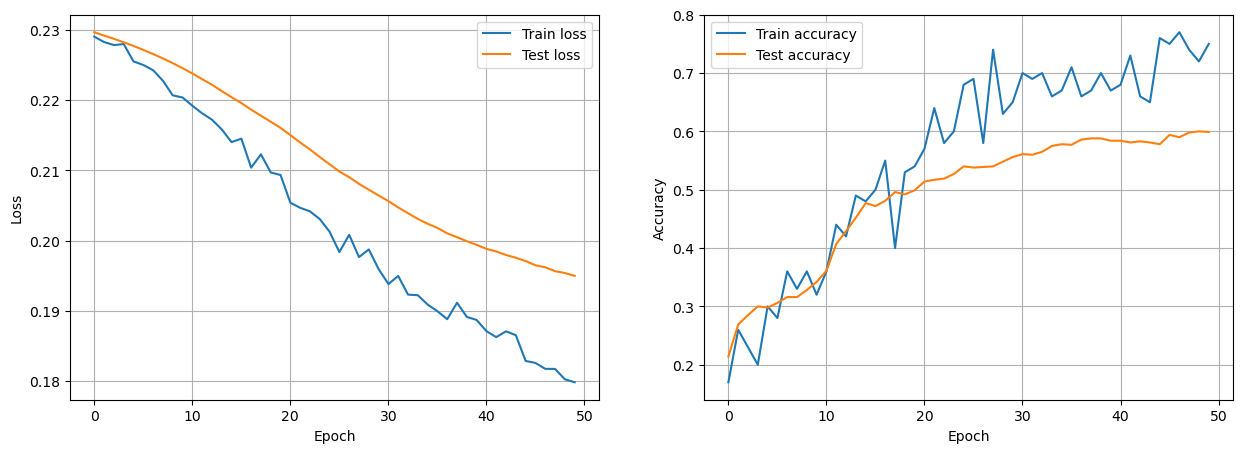

In [18]:
# Initialize NN and hyperparameters
torch.manual_seed(0)
model_with_dropout = MNISTNNDropout()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_with_dropout.parameters(), lr=0.05)
batch_size = 10
num_epochs = 50

# Choose train and test samples
n_train = 100
n_test = 1000 
mnist_train  = mnist_train_set[:n_train]
mnist_test   = mnist_test_set[:n_test]

print(f"Train dataset size: {len(mnist_train)}")
print(f"Test dataset size: {len(mnist_test)}\n")

# Run training (this may take a while, set log=True if you want to see the progress)
train(model_with_dropout,mnist_train,mnist_test,batch_size,num_epochs,log=False)

print('Correct performance after 50 epochs is: train_loss = 0.1799 | train_acc = 0.750 | test_loss = 0.1950 | test_acc = 0.599')